In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import product
import sklearn
import scipy.sparse 
import lightgbm 
import gc

In [2]:
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [4]:
sales_train = pd.read_csv('sales_train_v2.csv')
print('sales_train')
display(sales_train.head())

test = pd.read_csv('test.csv')
print('test')
display(test.head())

items = pd.read_csv('items.csv')
print('items')
display(items.head())

item_categories = pd.read_csv('item_categories.csv')
print('item_categories')
display(item_categories.head())

shops = pd.read_csv('shops.csv')
print('shops')
display(shops.head())

sample_submission = pd.read_csv('sample_submission.csv')
print('sample_submission')
display(sample_submission.head())

sales_train


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


test


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


items


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


item_categories


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


shops


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


sample_submission


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [5]:
print('sales_train')
display(sales_train.describe(include='all').T)

print('test')
display(test.describe(include='all').T)

print('items')
display(items.describe(include='all').T)

print('item_categories')
display(item_categories.describe(include='all').T)

print('shops')
display(shops.describe(include='all').T)

sales_train


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,2935849,1034,28.12.2013,9434,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_block_num,2.93585e+06,NaN,NaN,NaN,14.5699,9.42299,0,7,14,23,33
shop_id,2.93585e+06,NaN,NaN,NaN,33.0017,16.227,0,22,31,47,59
item_id,2.93585e+06,NaN,NaN,NaN,10197.2,6324.3,0,4476,9343,15684,22169
item_price,2.93585e+06,NaN,NaN,NaN,890.853,1729.8,-1,249,399,999,307980
item_cnt_day,2.93585e+06,NaN,NaN,NaN,1.24264,2.61883,-22,1,1,1,2169


test


,count,mean,std,min,25%,50%,75%,max
ID,214200.0,107099.500000,61834.358168,0.0,53549.75,107099.5,160649.25,214199.0
shop_id,214200.0,31.642857,17.561933,2.0,16.00,34.5,47.00,59.0
item_id,214200.0,11019.398627,6252.644590,30.0,5381.50,11203.0,16071.50,22167.0


items


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
item_name,22170,22170,"Need for Speed Undercover [Xbox 360, русская в...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_id,22170,NaN,NaN,NaN,11084.5,6400.07,0,5542.25,11084.5,16626.8,22169
item_category_id,22170,NaN,NaN,NaN,46.2908,15.9415,0,37,40,58,83


item_categories


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
item_category_name,84,84,Карты оплаты - Windows (Цифра),1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_category_id,84,NaN,NaN,NaN,41.5,24.3926,0,20.75,41.5,62.25,83


shops


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
shop_name,60,60,"Воронеж (Плехановская, 13)",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shop_id,60,NaN,NaN,NaN,29.5,17.4642,0,14.75,29.5,44.25,59


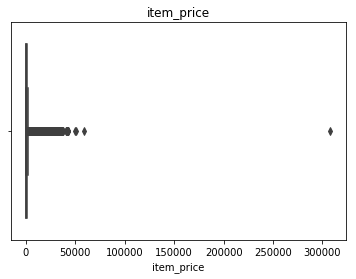

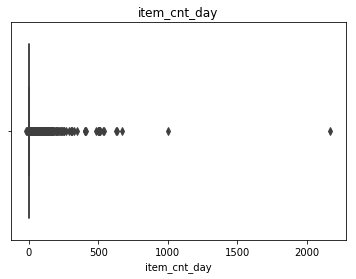

In [6]:
for col in ['item_price','item_cnt_day']:
    plt.figure()
    plt.title(col)
    sns.boxplot(x=sales_train[col]);

In [7]:
# removing outliers over 99 %

shape0 = sales_train.shape[0] # train size before dropping values
for col in ['item_price','item_cnt_day']:
    max_val = sales_train[col].quantile(.99) # get 99th percentile value
    sales_train = sales_train[sales_train[col]<max_val] # drop outliers
    print(f'{shape0-sales_train.shape[0]} {col} values over {max_val} removed')

print(f'new training set has {sales_train.shape[0]} records')

29543 item_price values over 5999.0 removed
66890 item_cnt_day values over 5.0 removed
new training set has 2868959 records


In [8]:
sales_train[sales_train['item_price']<=0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [9]:
sales_train=sales_train[sales_train['item_price']>0]

In [10]:
# feature matrix creation

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train.loc[sales_train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales_train.loc[sales_train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [11]:
print(grid.shape)
grid.head()

(10811561, 3)


,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [12]:
# appending test data to matrix with next month's date_block_num
# test file predicts next month

# latest month
grid['date_block_num'].max()

33

In [13]:
# append next month
test['date_block_num'] = 34
# add to grid
grid = pd.concat([grid, test[grid.columns]], ignore_index=True)
print('grid shape: ',grid.shape)
print('missing values:',grid.isna().sum())

grid shape:  (11025761, 3)
missing values: shop_id           0
item_id           0
date_block_num    0
dtype: int64


In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
# features creation
# creating monthly features from sales_train  and features aggregatd to monthly level

index_cols = ['shop_id', 'item_id', 'date_block_num']

# Groupby data to get shop-item-month aggregates
gb = sales_train.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum','trips':'size'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales_train.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum','trips_shop':'size'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales_train.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum','trips_item':'size'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

all_data.head()

,shop_id,item_id,date_block_num,target,trips,target_shop,trips_shop,target_item,trips_item
0,59,22154,0,1.0,1.0,1950.0,1816.0,18.0,18.0
1,59,2552,0,0.0,0.0,1950.0,1816.0,0.0,2.0
2,59,2554,0,0.0,0.0,1950.0,1816.0,1.0,1.0
3,59,2555,0,0.0,0.0,1950.0,1816.0,2.0,2.0
4,59,2564,0,0.0,0.0,1950.0,1816.0,5.0,5.0


In [16]:
# median item monthly price (using median to avoid outliers)
gb = sales_train.groupby(['date_block_num','item_id'],as_index=False).agg({'item_price':{'median_item_price':'median'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(all_data, gb, how='left', on=['date_block_num','item_id'])

# make sure no na values
print('na median_item_price:',all_data['median_item_price'].isna().sum())

na median_item_price: 214200


In [ ]:
# first item appearance feature
gb = all_data.groupby(['item_id'],as_index=False).agg({'date_block_num':{'item_first_month':'min'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(all_data, gb, how='left', on=['item_id'])

In [39]:
# use item_first_month to create new_item feature
all_data['new_item'] = (all_data['date_block_num'] == all_data['item_first_month'])
all_data['new_item'].value_counts()

False    10411178
True      1042983
Name: new_item, dtype: int64

In [40]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();
all_data.head()

,shop_id,item_id,date_block_num,target,trips,target_shop,trips_shop,target_item,trips_item,median_item_price,item_first_month,new_item
0,59,22154,0,1.0,1.0,1950.0,1816.0,18.0,18.0,999.000000,0,True
1,59,2552,0,0.0,0.0,1950.0,1816.0,0.0,2.0,899.000000,0,True
2,59,2554,0,0.0,0.0,1950.0,1816.0,1.0,1.0,1709.050049,0,True
3,59,2555,0,0.0,0.0,1950.0,1816.0,2.0,2.0,1098.849976,0,True
4,59,2564,0,0.0,0.0,1950.0,1816.0,5.0,5.0,349.000000,0,True


In [ ]:
# lag features from [1,2,3,4,5,12] months ago

# List of columns that we will use to create lags

cols_to_rename = list(all_data.columns.difference(index_cols+['item_first_month'])) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

In [ ]:
all_data.head(5)